# Reranking System Result Analysis

This notebook analyzes the enhanced reranking results from `stage8_enhanced_rerank_detailed.json` to understand the performance characteristics of the multi-stage reranking system.

**Key Questions:**
1. How often does the candidate list not include the ground truth?
2. When does LightGCN perform worse than Round 1 (LLM-only)?
3. Why does Round 2 sometimes perform worse than LightGCN when LightGCN was better?
4. When does Round 2 improve over LightGCN?

## 1. Setup & Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Markdown

# Load the data
data_path = '/home/zhenkai/personal/Projects/AgenticRecommender/outputs/202601262250/stage8_enhanced_rerank_detailed.json'
with open(data_path) as f:
    data = json.load(f)

print(f"Total records: {len(data)}")

Total records: 1000


## 2. Data Overview

In [2]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)

# Extract ground_truth_added from nested candidate_info
df['ground_truth_added'] = df['candidate_info'].apply(lambda x: x.get('ground_truth_added', False))
df['history_cuisines'] = df['candidate_info'].apply(lambda x: x.get('history_cuisines', []))

print("Columns:", list(df.columns))
print("\nBasic Statistics:")
df[['round1_rank', 'lightgcn_rank', 'final_rank']].describe()

Columns: ['sample_idx', 'customer_id', 'ground_truth', 'candidates', 'candidate_info', 'round1_ranking', 'round1_reasoning', 'lightgcn_scores', 'lightgcn_ranking', 'lightgcn_rank', 'final_ranking', 'final_reflection', 'round1_rank', 'final_rank', 'time_ms', 'ground_truth_added', 'history_cuisines']

Basic Statistics:


,round1_rank,lightgcn_rank,final_rank
count,1000.000000,1000.000000,1000.000000
mean,3.219000,1.459000,1.640000
std,1.536685,1.018507,1.197428
min,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000
50%,3.000000,1.000000,1.000000
75%,4.000000,1.000000,2.000000
max,6.000000,6.000000,6.000000


In [3]:
# ── Case Lookup System ────────────────────────────────────────
# Two hashmaps for instant lookup by sample_idx or customer_id.
#
#   lookup(18)                     → pretty-print case #18
#   case_by_idx[18]                → raw dict for case #18
#   lookup_customer('abc...')      → pretty-print all cases for a customer
#   cases_by_customer['abc...']    → raw list of dicts for a customer

from collections import defaultdict

case_by_idx = {r['sample_idx']: r for r in data}

_by_cust = defaultdict(list)
for r in data:
    _by_cust[r['customer_id']].append(r)
cases_by_customer = dict(_by_cust)

def lookup(sample_idx):
    """Pretty-print a single test case by sample_idx. Returns the raw dict."""
    c = case_by_idx.get(sample_idx)
    if c is None:
        print(f"No case with sample_idx={sample_idx}")
        return None
    ci = c.get('candidate_info', {})
    print(f"Sample {c['sample_idx']}  |  Customer: {c['customer_id']}")
    print(f"  Ground truth:      {c['ground_truth']}")
    print(f"  GT added to cands: {ci.get('ground_truth_added', False)}")
    print(f"  History cuisines:  {ci.get('history_cuisines', [])}")
    print(f"  Candidates:        {c['candidates']}")
    print(f"  Ranks  →  Round1={c['round1_rank']}  |  LightGCN={c['lightgcn_rank']}  |  Final={c['final_rank']}")
    print(f"  Round1 ranking:    {c['round1_ranking']}")
    print(f"  LightGCN ranking:  {c['lightgcn_ranking']}")
    print(f"  Final ranking:     {c['final_ranking']}")
    print(f"  LightGCN scores:")
    for item, score in c['lightgcn_scores']:
        tag = "  ◄ GT" if item == c['ground_truth'] else ""
        print(f"    {item}: {score:.3f}{tag}")
    print(f"  Round1 reasoning:  {c['round1_reasoning'][:300]}...")
    refl = c.get('final_reflection', '')
    print(f"  Final reflection:  {refl[:300]}..." if refl else "  Final reflection:  (empty)")
    return c

def lookup_customer(customer_id):
    """Pretty-print all test cases for a given customer_id. Returns list of raw dicts."""
    cases = cases_by_customer.get(customer_id, [])
    if not cases:
        print(f"No cases for customer_id={customer_id}")
        return []
    print(f"{len(cases)} case(s) for customer {customer_id}:")
    for c in cases:
        gt_added = c.get('candidate_info', {}).get('ground_truth_added', False)
        print(f"  idx={c['sample_idx']}  GT={c['ground_truth']}  "
              f"R1={c['round1_rank']} LGCN={c['lightgcn_rank']} Final={c['final_rank']}  "
              f"GT_added={gt_added}")
    return cases

print(f"Lookup indices ready:")
print(f"  case_by_idx       → {len(case_by_idx)} cases (e.g., lookup(18))")
print(f"  cases_by_customer → {len(cases_by_customer)} unique customers (e.g., lookup_customer('...'))")
print(f"\nSample customer IDs: {list(cases_by_customer.keys())[:5]}")

Lookup indices ready:
  case_by_idx       → 1000 cases (e.g., lookup(18))
  cases_by_customer → 543 unique customers (e.g., lookup_customer('...'))

Sample customer IDs: ['b891db99d5', 'c64306b778', '79ad6f2c0d', '0300cbf2ff', '9e7d147126']


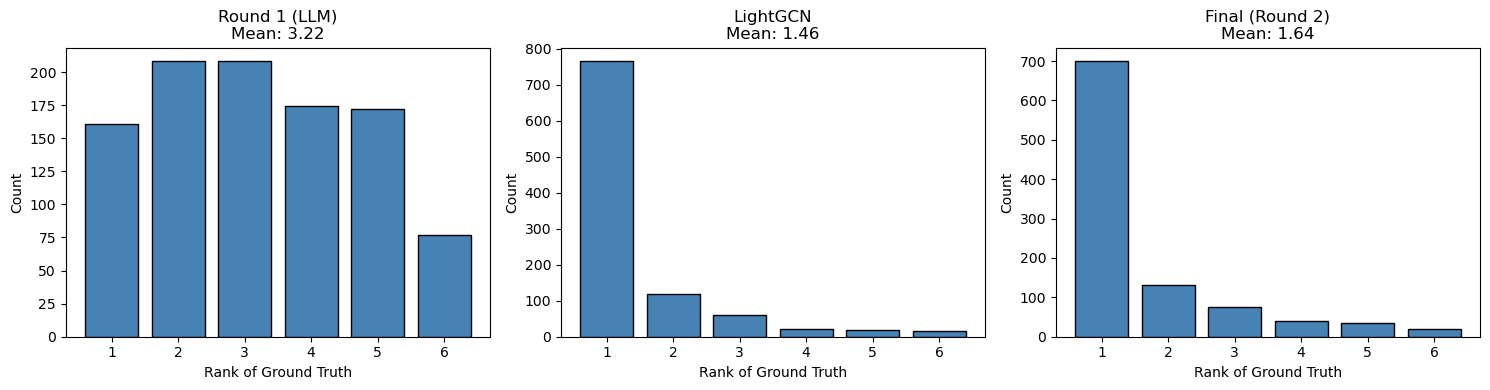


Hit@1 Rates:
  Round 1 (LLM):    16.1%
  LightGCN:         76.4%
  Final (Round 2):  69.9%


In [4]:
# Rank distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, title in zip(axes, ['round1_rank', 'lightgcn_rank', 'final_rank'], 
                          ['Round 1 (LLM)', 'LightGCN', 'Final (Round 2)']):
    rank_counts = df[col].value_counts().sort_index()
    ax.bar(rank_counts.index, rank_counts.values, color='steelblue', edgecolor='black')
    ax.set_xlabel('Rank of Ground Truth')
    ax.set_ylabel('Count')
    ax.set_title(f'{title}\nMean: {df[col].mean():.2f}')
    ax.set_xticks(range(1, 7))

plt.tight_layout()
plt.show()

# Hit rates
print("\nHit@1 Rates:")
print(f"  Round 1 (LLM):    {(df['round1_rank'] == 1).mean()*100:.1f}%")
print(f"  LightGCN:         {(df['lightgcn_rank'] == 1).mean()*100:.1f}%")
print(f"  Final (Round 2):  {(df['final_rank'] == 1).mean()*100:.1f}%")

Ground truth originally in candidates: 22 (2.2%)  →  gt_not_added_cases
Ground truth had to be added:          978 (97.8%)  →  gt_added_cases


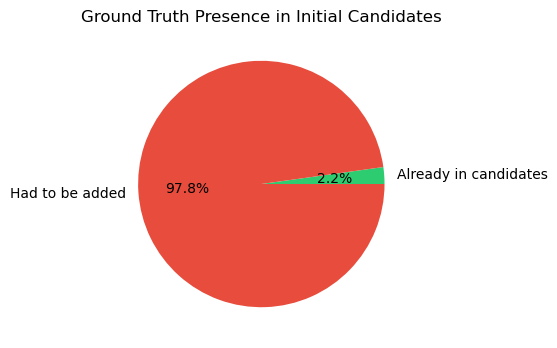

In [5]:
# Filtered subsets — use these variables directly for inspection
#   gt_added_cases     → cases where ground truth had to be added to candidates
#   gt_not_added_cases → cases where ground truth was already in candidates
gt_added_cases = df[df['ground_truth_added'] == True].copy()
gt_not_added_cases = df[df['ground_truth_added'] == False].copy()

print(f"Ground truth originally in candidates: {len(gt_not_added_cases)} ({len(gt_not_added_cases)/len(df)*100:.1f}%)  →  gt_not_added_cases")
print(f"Ground truth had to be added:          {len(gt_added_cases)} ({len(gt_added_cases)/len(df)*100:.1f}%)  →  gt_added_cases")

# Visualize
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie([len(gt_not_added_cases), len(gt_added_cases)], 
       labels=['Already in candidates', 'Had to be added'],
       autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
ax.set_title('Ground Truth Presence in Initial Candidates')
plt.show()

In [32]:
# Show examples where ground truth was added (using gt_added_cases from above)
print(f"Examples where ground truth had to be added to candidates ({len(gt_added_cases)} total, showing first 3):")
print("="*80)
for _, row in gt_added_cases.head(3).iterrows():

    print(f"\nSample {row['sample_idx']}:")
    print(f"  Customer ID: {row['customer_id']}")
    print(f"  Ground truth: {row['ground_truth']}")
    print(f"  History cuisines: {row['history_cuisines']}")
    print(f"  Candidates: {row['candidates']}")

Examples where ground truth had to be added to candidates (978 total, showing first 3):

Sample 18:
  Customer ID: b891db99d5
  Ground truth: cd53e068||thai
  History cuisines: ['kafé', 'vegetariskt', 'burgare', 'sushi', 'sallad', 'mellanöstern', 'thai']
  Candidates: ['e1f3e4a4||italienskt', 'cd53e068||thai', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

Sample 26:
  Customer ID: c64306b778
  Ground truth: fc16158e||pizza
  History cuisines: ['pizza', 'asiatiskt']
  Candidates: ['e1f3e4a4||italienskt', 'fc16158e||pizza', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

Sample 6:
  Customer ID: 79ad6f2c0d
  Ground truth: cd8d7e52||sushi
  History cuisines: ['pizza', 'sushi']
  Candidates: ['e1f3e4a4||italienskt', 'cd8d7e52||sushi', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']


In [7]:
# Show examples where ground truth was added
gt_added_examples = df[df['ground_truth_added'] == True].head(3)

print("Examples where ground truth had to be added to candidates:")
print("="*80)
for _, row in gt_added_examples.iterrows():
    print(f"\nSample {row['sample_idx']}:")
    print(f"  Ground truth: {row['ground_truth']}")
    print(f"  History cuisines: {row['history_cuisines']}")
    print(f"  Candidates: {row['candidates']}")

Examples where ground truth had to be added to candidates:

Sample 18:
  Ground truth: cd53e068||thai
  History cuisines: ['kafé', 'vegetariskt', 'burgare', 'sushi', 'sallad', 'mellanöstern', 'thai']
  Candidates: ['e1f3e4a4||italienskt', 'cd53e068||thai', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

Sample 26:
  Ground truth: fc16158e||pizza
  History cuisines: ['pizza', 'asiatiskt']
  Candidates: ['e1f3e4a4||italienskt', 'fc16158e||pizza', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

Sample 6:
  Ground truth: cd8d7e52||sushi
  History cuisines: ['pizza', 'sushi']
  Candidates: ['e1f3e4a4||italienskt', 'cd8d7e52||sushi', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']


LightGCN vs Round 1 Comparison:
  LightGCN better:  739 (73.9%)  →  lightgcn_better_df
  Same rank:        196 (19.6%)  →  lightgcn_same_df
  LightGCN worse:   65 (6.5%)  →  lightgcn_worse_df


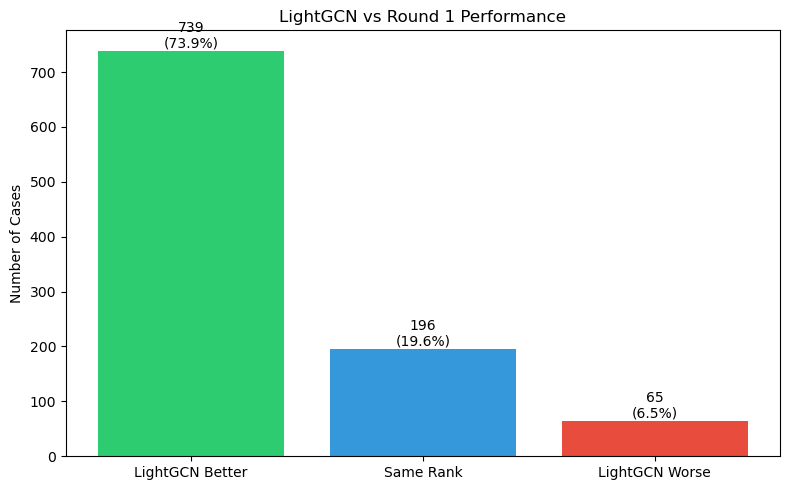

In [8]:
# Compare LightGCN vs Round 1
df['lightgcn_worse_than_r1'] = df['lightgcn_rank'] > df['round1_rank']
df['lightgcn_better_than_r1'] = df['lightgcn_rank'] < df['round1_rank']
df['lightgcn_same_as_r1'] = df['lightgcn_rank'] == df['round1_rank']

# Filtered subsets — use these variables directly for inspection
#   lightgcn_better_df → cases where LightGCN outperformed Round 1
#   lightgcn_same_df   → cases where they tied
#   lightgcn_worse_df  → cases where LightGCN was worse than Round 1
lightgcn_better_df = df[df['lightgcn_better_than_r1']].copy()
lightgcn_same_df = df[df['lightgcn_same_as_r1']].copy()
lightgcn_worse_df = df[df['lightgcn_worse_than_r1']].copy()

print(f"LightGCN vs Round 1 Comparison:")
print(f"  LightGCN better:  {len(lightgcn_better_df)} ({len(lightgcn_better_df)/len(df)*100:.1f}%)  →  lightgcn_better_df")
print(f"  Same rank:        {len(lightgcn_same_df)} ({len(lightgcn_same_df)/len(df)*100:.1f}%)  →  lightgcn_same_df")
print(f"  LightGCN worse:   {len(lightgcn_worse_df)} ({len(lightgcn_worse_df)/len(df)*100:.1f}%)  →  lightgcn_worse_df")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['LightGCN Better', 'Same Rank', 'LightGCN Worse'], 
              [len(lightgcn_better_df), len(lightgcn_same_df), len(lightgcn_worse_df)],
              color=['#2ecc71', '#3498db', '#e74c3c'])
ax.set_ylabel('Number of Cases')
ax.set_title('LightGCN vs Round 1 Performance')
for bar, count in zip(bars, [len(lightgcn_better_df), len(lightgcn_same_df), len(lightgcn_worse_df)]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{count}\n({count/len(df)*100:.1f}%)', ha='center')
plt.tight_layout()
plt.show()

In [9]:
# Analyze the rank difference distribution when LightGCN is worse
# (uses lightgcn_worse_df defined above — already a .copy(), safe to modify)
lightgcn_worse_df['rank_diff'] = lightgcn_worse_df['lightgcn_rank'] - lightgcn_worse_df['round1_rank']

print(f"When LightGCN is worse ({len(lightgcn_worse_df)} cases):")
print(f"  Mean rank drop: {lightgcn_worse_df['rank_diff'].mean():.2f} positions")
print(f"\nRank difference distribution:")
print(lightgcn_worse_df['rank_diff'].value_counts().sort_index())

When LightGCN is worse (65 cases):
  Mean rank drop: 1.55 positions

Rank difference distribution:
rank_diff
1    43
2    12
3     6
4     4
Name: count, dtype: int64


In [10]:
# Analyze the rank difference distribution when LightGCN is worse
lightgcn_worse_df = df[df['lightgcn_worse_than_r1']]
lightgcn_worse_df['rank_diff'] = lightgcn_worse_df['lightgcn_rank'] - lightgcn_worse_df['round1_rank']

print(f"When LightGCN is worse ({len(lightgcn_worse_df)} cases):")
print(f"  Mean rank drop: {lightgcn_worse_df['rank_diff'].mean():.2f} positions")
print(f"\nRank difference distribution:")
print(lightgcn_worse_df['rank_diff'].value_counts().sort_index())

When LightGCN is worse (65 cases):
  Mean rank drop: 1.55 positions

Rank difference distribution:
rank_diff
1    43
2    12
3     6
4     4
Name: count, dtype: int64


/tmp/ipykernel_49170/196916391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lightgcn_worse_df['rank_diff'] = lightgcn_worse_df['lightgcn_rank'] - lightgcn_worse_df['round1_rank']


In [33]:
# Show sample cases where LightGCN performed worse
print("Sample cases where LightGCN performed worse than Round 1:")
print("="*80)

for _, row in lightgcn_worse_df.head(3).iterrows():
    print(f"\nSample {row['sample_idx']}:")
    print(f"  Customer ID: {row['customer_id']}")
    print(f"  Ground truth: {row['ground_truth']}")
    print(f"  Round 1 rank: {row['round1_rank']} | LightGCN rank: {row['lightgcn_rank']}")
    print(f"  History: {row['history_cuisines']}")
    print(f"  Round 1 reasoning: {row['round1_reasoning'][:200]}...")
    print(f"  LightGCN scores: {row['lightgcn_scores'][:3]}...")

Sample cases where LightGCN performed worse than Round 1:

Sample 15:
  Customer ID: 3d86a594f8
  Ground truth: 5b6a88d8||pizza
  Round 1 rank: 1 | LightGCN rank: 2
  History: ['kebab', 'burgare']
  Round 1 reasoning: Pizza is a common dinner choice and aligns with the target time (Sun 18:00). Italian cuisine (pastas) is also dinner-appropriate. Sushi and Asian cuisines are less likely for quick dinners. Kebab and ...
  LightGCN scores: [['e1f3e4a4||italienskt', 1.3648419380187988], ['5b6a88d8||pizza', 0.9314151406288147], ['9341773e||pizza', 0.8516684770584106]]...

Sample 72:
  Customer ID: 8ff430e17c
  Ground truth: 27e26b2b||pizza
  Round 1 rank: 4 | LightGCN rank: 5
  History: ['sushi', 'thai']
  Round 1 reasoning: Sushi is most likely due to 2 prior orders. Pizza is next as a common choice with 3 candidates. Asiatiskt follows due to prior Thai (Asian) order. Italian is least likely as it's new and unrelated to ...
  LightGCN scores: [['2ebe1498||pizza', 4.620388984680176], ['5d1b

## 5. Q3: Why Does Round 2 Hurt When LightGCN Was Better?

In [12]:
# Find cases where:
# 1. LightGCN was better than Round 1 (lightgcn_rank < round1_rank)
# 2. But Final/Round 2 is worse than LightGCN (final_rank > lightgcn_rank)

df['lightgcn_was_better'] = df['lightgcn_rank'] < df['round1_rank']
df['final_worse_than_lightgcn'] = df['final_rank'] > df['lightgcn_rank']

# Cases where Round 2 hurt the LightGCN advantage
hurt_cases = df[df['lightgcn_was_better'] & df['final_worse_than_lightgcn']]

print(f"Cases where LightGCN was better than Round 1: {df['lightgcn_was_better'].sum()}")
print(f"Of those, cases where Round 2 made it worse: {len(hurt_cases)} ({len(hurt_cases)/df['lightgcn_was_better'].sum()*100:.1f}%)")

Cases where LightGCN was better than Round 1: 739
Of those, cases where Round 2 made it worse: 94 (12.7%)


In [13]:
# Deep dive into the hurt cases - analyze the reasoning
print(f"Analyzing {len(hurt_cases)} cases where Round 2 hurt LightGCN's advantage:")
print("="*80)

for i, (_, row) in enumerate(hurt_cases.head(5).iterrows()):
    print(f"\n{'='*80}")
    print(f"Case {i+1} (Sample {row['sample_idx']}):")
    print(f"  Ground truth: {row['ground_truth']}")
    print(f"  Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    print(f"\n  History cuisines: {row['history_cuisines']}")
    print(f"\n  Round 1 ranking: {row['round1_ranking']}")
    print(f"  LightGCN ranking: {row['lightgcn_ranking']}")
    print(f"  Final ranking: {row['final_ranking']}")
    print(f"\n  Final Reflection (why Round 2 made this decision):")
    print(f"  {row['final_reflection']}")

Analyzing 94 cases where Round 2 hurt LightGCN's advantage:

Case 1 (Sample 69):
  Ground truth: de91b17e||pizza
  Ranks: Round1=3 -> LightGCN=1 -> Final=6

  History cuisines: ['pizza', 'thai', 'asiatiskt']

  Round 1 ranking: ['5d1b1300||asiatiskt', '9341773e||pizza', 'de91b17e||pizza', '2ebe1498||pizza', '4790e97d||sushi', 'e1f3e4a4||italienskt']
  LightGCN ranking: ['de91b17e||pizza', '9341773e||pizza', '2ebe1498||pizza', '4790e97d||sushi', 'e1f3e4a4||italienskt', '5d1b1300||asiatiskt']
  Final ranking: ['9341773e||pizza', '2ebe1498||pizza', '5d1b1300||asiatiskt', '4790e97d||sushi', 'e1f3e4a4||italienskt', 'de91b17e||pizza']

  Final Reflection (why Round 2 made this decision):
  The user's recent history shows a strong preference for 'thai' and 'asiatiskt', followed by 'pizza'. The initial LLM ranking emphasized 'asiatiskt' at the top, but the collaborative filtering (LightGCN) signals strongly favor 'pizza' (especially 'de91b1773e||pizza') with high similarity scores. However, th

In [14]:
# Categorize failure patterns based on reflection text
failure_patterns = {
    'preferred_llm_ranking': 0,
    'negative_collaborative_score': 0,
    'balanced_approach_backfired': 0,
    'recency_bias': 0,
    'other': 0
}

for _, row in hurt_cases.iterrows():
    reflection = row['final_reflection'].lower()
    
    if 'llm ranking' in reflection or 'initial ranking' in reflection:
        failure_patterns['preferred_llm_ranking'] += 1
    elif 'negative' in reflection and ('score' in reflection or 'collaborative' in reflection):
        failure_patterns['negative_collaborative_score'] += 1
    elif 'balanc' in reflection:
        failure_patterns['balanced_approach_backfired'] += 1
    elif 'recent' in reflection:
        failure_patterns['recency_bias'] += 1
    else:
        failure_patterns['other'] += 1

print("Potential failure pattern categorization:")
for pattern, count in sorted(failure_patterns.items(), key=lambda x: -x[1]):
    if count > 0:
        print(f"  {pattern}: {count} ({count/len(hurt_cases)*100:.1f}%)")

Potential failure pattern categorization:
  preferred_llm_ranking: 49 (52.1%)
  other: 21 (22.3%)
  negative_collaborative_score: 20 (21.3%)
  balanced_approach_backfired: 3 (3.2%)
  recency_bias: 1 (1.1%)


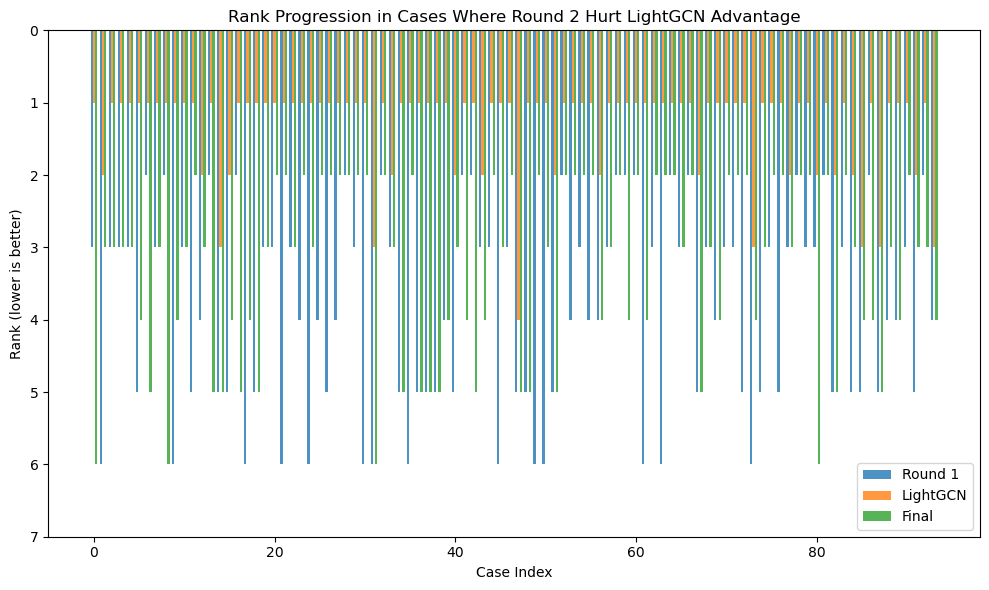

In [15]:
# Visualize the rank changes in hurt cases
if len(hurt_cases) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = range(len(hurt_cases))
    width = 0.25
    
    ax.bar([i - width for i in x], hurt_cases['round1_rank'], width, label='Round 1', alpha=0.8)
    ax.bar([i for i in x], hurt_cases['lightgcn_rank'], width, label='LightGCN', alpha=0.8)
    ax.bar([i + width for i in x], hurt_cases['final_rank'], width, label='Final', alpha=0.8)
    
    ax.set_xlabel('Case Index')
    ax.set_ylabel('Rank (lower is better)')
    ax.set_title('Rank Progression in Cases Where Round 2 Hurt LightGCN Advantage')
    ax.legend()
    ax.set_ylim(0, 7)
    ax.invert_yaxis()  # Lower rank is better
    plt.tight_layout()
    plt.show()

### 5.1 Detailed Examples by Failure Category

Let's examine specific examples for each failure pattern to understand what went wrong.

In [16]:
# Improved categorization function
def categorize_failure(row):
    reflection = row['final_reflection'].lower()
    
    # Check for empty reflection first
    if not reflection.strip():
        return 'empty_reflection'
    
    if 'llm ranking' in reflection or 'initial ranking' in reflection or ('llm' in reflection and 'rank' in reflection):
        return 'preferred_llm_ranking'
    elif 'negative' in reflection and ('score' in reflection or 'collaborative' in reflection or 'signal' in reflection):
        return 'negative_score_mishandling'
    elif 'balanc' in reflection:
        return 'balanced_approach_backfired'
    elif 'recent' in reflection and ('history' in reflection or 'prefer' in reflection):
        return 'recency_bias'
    else:
        return 'other'

hurt_cases_detailed = hurt_cases.copy()
hurt_cases_detailed['failure_category'] = hurt_cases_detailed.apply(categorize_failure, axis=1)

# Show counts
print("Failure Category Distribution:")
print("="*60)
category_counts = hurt_cases_detailed['failure_category'].value_counts()
for cat, count in category_counts.items():
    print(f"  {cat}: {count} ({count/len(hurt_cases_detailed)*100:.1f}%)")

Failure Category Distribution:
  preferred_llm_ranking: 54 (57.4%)
  empty_reflection: 21 (22.3%)
  negative_score_mishandling: 15 (16.0%)
  balanced_approach_backfired: 3 (3.2%)
  recency_bias: 1 (1.1%)


#### Category 1: Preferred LLM Ranking (Most Common - ~55%)

**Problem**: The model gives too much weight to the initial LLM ranking, overriding LightGCN's strong collaborative filtering signals.

In [17]:
# Example: Preferred LLM Ranking
cat1_examples = hurt_cases_detailed[hurt_cases_detailed['failure_category'] == 'preferred_llm_ranking']
if len(cat1_examples) > 0:
    row = cat1_examples.iloc[0]
    
    print("EXAMPLE: Preferred LLM Ranking Over Strong CF Signal")
    print("="*80)
    print(f"Sample {row['sample_idx']} | Ground truth: {row['ground_truth']}")
    print(f"Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    print(f"\nUser History: {row['history_cuisines']}")
    
    print(f"\n--- Rankings ---")
    print(f"Round 1 (LLM):  {row['round1_ranking']}")
    print(f"LightGCN:       {row['lightgcn_ranking']}")
    print(f"Final:          {row['final_ranking']}")
    
    print(f"\n--- LightGCN Scores ---")
    for item, score in row['lightgcn_scores']:
        marker = " <-- GROUND TRUTH" if item == row['ground_truth'] else ""
        print(f"  {item}: {score:.3f}{marker}")
    
    print(f"\n--- Final Reflection ---")
    print(row['final_reflection'])
    
    print("\n" + "="*80)
    print("ANALYSIS: LightGCN gave ground truth score 8.003 (highest by far!)")
    print("But Round 2 moved it to rank 6 because it prioritized the LLM's")
    print("'asiatiskt' preference over the strong collaborative signal.")

EXAMPLE: Preferred LLM Ranking Over Strong CF Signal
Sample 69 | Ground truth: de91b17e||pizza
Ranks: Round1=3 -> LightGCN=1 -> Final=6

User History: ['pizza', 'thai', 'asiatiskt']

--- Rankings ---
Round 1 (LLM):  ['5d1b1300||asiatiskt', '9341773e||pizza', 'de91b17e||pizza', '2ebe1498||pizza', '4790e97d||sushi', 'e1f3e4a4||italienskt']
LightGCN:       ['de91b17e||pizza', '9341773e||pizza', '2ebe1498||pizza', '4790e97d||sushi', 'e1f3e4a4||italienskt', '5d1b1300||asiatiskt']
Final:          ['9341773e||pizza', '2ebe1498||pizza', '5d1b1300||asiatiskt', '4790e97d||sushi', 'e1f3e4a4||italienskt', 'de91b17e||pizza']

--- LightGCN Scores ---
  de91b17e||pizza: 8.003 <-- GROUND TRUTH
  9341773e||pizza: 0.479
  2ebe1498||pizza: 0.384
  4790e97d||sushi: 0.121
  e1f3e4a4||italienskt: 0.118
  5d1b1300||asiatiskt: -2.773

--- Final Reflection ---
The user's recent history shows a strong preference for 'thai' and 'asiatiskt', followed by 'pizza'. The initial LLM ranking emphasized 'asiatiskt' at t

#### Category 2: Negative Score Mishandling (~15%)

**Problem**: The model incorrectly interprets or avoids items with negative collaborative scores, even when the ground truth has the highest (positive) score.

In [18]:
# Example: Negative Score Mishandling
cat2_examples = hurt_cases_detailed[hurt_cases_detailed['failure_category'] == 'negative_score_mishandling']
if len(cat2_examples) > 0:
    row = cat2_examples.iloc[0]
    
    print("EXAMPLE: Negative Score Mishandling")
    print("="*80)
    print(f"Sample {row['sample_idx']} | Ground truth: {row['ground_truth']}")
    print(f"Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    print(f"\nUser History: {row['history_cuisines']}")
    
    print(f"\n--- LightGCN Scores ---")
    for item, score in row['lightgcn_scores']:
        marker = " <-- GROUND TRUTH" if item == row['ground_truth'] else ""
        sign = "+" if score > 0 else ""
        print(f"  {item}: {sign}{score:.3f}{marker}")
    
    print(f"\n--- Rankings ---")
    print(f"Round 1:   {row['round1_ranking']}")
    print(f"LightGCN:  {row['lightgcn_ranking']}")  
    print(f"Final:     {row['final_ranking']}")
    
    print(f"\n--- Final Reflection ---")
    print(row['final_reflection'])
    
    print("\n" + "="*80)
    print("ANALYSIS: Ground truth 'thai' has the highest score (6.127).")
    print("But the model demoted it because it mentioned avoiding 'Italian'")
    print("due to its negative score (-0.901), conflating the logic for all items.")

EXAMPLE: Negative Score Mishandling
Sample 63 | Ground truth: 8b24ce41||kafé
Ranks: Round1=3 -> LightGCN=1 -> Final=3

User History: ['burgare', 'vegetariskt', 'thai', 'kafé', 'unknown', 'pizza', 'libanesiskt', 'asiatiskt']

--- LightGCN Scores ---
  8b24ce41||kafé: +6.888 <-- GROUND TRUTH
  e1f3e4a4||italienskt: +2.540
  9341773e||pizza: +1.009
  2ebe1498||pizza: -0.236
  5d1b1300||asiatiskt: -1.460
  4790e97d||sushi: -2.703

--- Rankings ---
Round 1:   ['e1f3e4a4||italienskt', '5d1b1300||asiatiskt', '8b24ce41||kafé', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']
LightGCN:  ['8b24ce41||kafé', 'e1f3e4a4||italienskt', '9341773e||pizza', '2ebe1498||pizza', '5d1b1300||asiatiskt', '4790e97d||sushi']
Final:     ['e1f3e4a4||italienskt', '5d1b1300||asiatiskt', '8b24ce41||kafé', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

--- Final Reflection ---
The final ranking prioritizes the collaborative filtering scores for cuisines with available signals (kafé, italienskt, pizz

#### Category 3: Balanced Approach Backfired (~3%)

**Problem**: The model tries to "balance" user history with collaborative signals but ends up prioritizing the wrong items.

In [19]:
# Example: Balanced Approach Backfired
cat3_examples = hurt_cases_detailed[hurt_cases_detailed['failure_category'] == 'balanced_approach_backfired']
if len(cat3_examples) > 0:
    row = cat3_examples.iloc[0]
    
    print("EXAMPLE: Balanced Approach Backfired")
    print("="*80)
    print(f"Sample {row['sample_idx']} | Ground truth: {row['ground_truth']}")
    print(f"Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    print(f"\nUser History: {row['history_cuisines']}")
    
    print(f"\n--- LightGCN Scores ---")
    for item, score in row['lightgcn_scores']:
        marker = " <-- GROUND TRUTH" if item == row['ground_truth'] else ""
        print(f"  {item}: {score:.3f}{marker}")
    
    print(f"\n--- Rankings ---")
    print(f"LightGCN:  {row['lightgcn_ranking']}")  
    print(f"Final:     {row['final_ranking']}")
    
    print(f"\n--- Final Reflection ---")
    print(row['final_reflection'])
    
    print("\n" + "="*80)
    print("ANALYSIS: Ground truth pizza (6b0aec8c) had highest CF score (7.990)")
    print("but got moved to rank 5. The 'balancing' pushed Italian and Asian")
    print("to top despite much weaker CF signals (1.756 and 1.342).")

EXAMPLE: Balanced Approach Backfired
Sample 191 | Ground truth: 7fab4221||sushi
Ranks: Round1=5 -> LightGCN=3 -> Final=5

User History: ['asiatiskt', 'thai', 'pizza', 'mexikanskt']

--- LightGCN Scores ---
  4790e97d||sushi: 7.636
  2ebe1498||pizza: 5.187
  7fab4221||sushi: 5.072 <-- GROUND TRUTH
  5d1b1300||asiatiskt: 4.250
  e1f3e4a4||italienskt: 3.188
  9341773e||pizza: 1.253

--- Rankings ---
LightGCN:  ['4790e97d||sushi', '2ebe1498||pizza', '7fab4221||sushi', '5d1b1300||asiatiskt', 'e1f3e4a4||italienskt', '9341773e||pizza']
Final:     ['e1f3e4a4||italienskt', '5d1b1300||asiatiskt', '4790e97d||sushi', '2ebe1498||pizza', '7fab4221||sushi', '9341773e||pizza']

--- Final Reflection ---
The final ranking prioritized collaborative filtering (CF) signals for cuisines with high similarity scores (sushi and pizza), followed by 'asiatiskt' which aligns with the user's recent history and has a moderate CF score. 'Italienskt' was included next due to its CF score, while 'mexikanskt' and 'thai

#### Category 4: Empty Reflection / Other (~22%)

**Problem**: The model either produces no reflection (likely a parsing/generation issue) or the reasoning doesn't fit other patterns. Often the final ranking simply copies Round 1.

In [20]:
# Example: Empty Reflection / Fallback to Round 1
cat4_examples = hurt_cases_detailed[hurt_cases_detailed['failure_category'].isin(['empty_reflection', 'other'])]
if len(cat4_examples) > 0:
    row = cat4_examples.iloc[0]
    
    print("EXAMPLE: Empty Reflection - Defaulted to Round 1 Ranking")
    print("="*80)
    print(f"Sample {row['sample_idx']} | Ground truth: {row['ground_truth']}")
    print(f"Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    
    print(f"\n--- LightGCN Scores ---")
    for item, score in row['lightgcn_scores']:
        marker = " <-- GROUND TRUTH (HIGHEST!)" if item == row['ground_truth'] else ""
        print(f"  {item}: {score:.3f}{marker}")
    
    print(f"\n--- Rankings Comparison ---")
    print(f"Round 1:   {row['round1_ranking']}")
    print(f"LightGCN:  {row['lightgcn_ranking']}")
    print(f"Final:     {row['final_ranking']}")
    
    print(f"\n--- Final Reflection ---")
    print(f"'{row['final_reflection']}'" if row['final_reflection'] else "(EMPTY)")
    
    # Check if final matches round1
    if row['final_ranking'] == row['round1_ranking']:
        print("\n" + "="*80)
        print("ANALYSIS: Final ranking is IDENTICAL to Round 1!")
        print("With empty reflection, the system defaulted to Round 1,")
        print("completely ignoring LightGCN's superior ranking.")

EXAMPLE: Empty Reflection - Defaulted to Round 1 Ranking
Sample 16 | Ground truth: 6a09aaf4||kafé
Ranks: Round1=3 -> LightGCN=1 -> Final=3

--- LightGCN Scores ---
  6a09aaf4||kafé: 5.640 <-- GROUND TRUTH (HIGHEST!)
  5d1b1300||asiatiskt: 0.913
  9341773e||pizza: -1.527
  2ebe1498||pizza: -1.706
  4790e97d||sushi: -2.212
  e1f3e4a4||italienskt: -2.343

--- Rankings Comparison ---
Round 1:   ['e1f3e4a4||italienskt', '5d1b1300||asiatiskt', '6a09aaf4||kafé', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']
LightGCN:  ['6a09aaf4||kafé', '5d1b1300||asiatiskt', '9341773e||pizza', '2ebe1498||pizza', '4790e97d||sushi', 'e1f3e4a4||italienskt']
Final:     ['e1f3e4a4||italienskt', '5d1b1300||asiatiskt', '6a09aaf4||kafé', '4790e97d||sushi', '2ebe1498||pizza', '9341773e||pizza']

--- Final Reflection ---
(EMPTY)

ANALYSIS: Final ranking is IDENTICAL to Round 1!
With empty reflection, the system defaulted to Round 1,
completely ignoring LightGCN's superior ranking.


## 6. Q4: Cases Where Round 2 Improves Over LightGCN

In [21]:
# Find cases where Round 2 improved over LightGCN
df['final_better_than_lightgcn'] = df['final_rank'] < df['lightgcn_rank']
improved_cases = df[df['final_better_than_lightgcn']]

print(f"Cases where Round 2 improved over LightGCN: {len(improved_cases)} ({len(improved_cases)/len(df)*100:.1f}%)")
print(f"Cases where Round 2 same as LightGCN: {(df['final_rank'] == df['lightgcn_rank']).sum()}")
print(f"Cases where Round 2 worse than LightGCN: {(df['final_rank'] > df['lightgcn_rank']).sum()}")

Cases where Round 2 improved over LightGCN: 19 (1.9%)
Cases where Round 2 same as LightGCN: 867
Cases where Round 2 worse than LightGCN: 114


In [22]:
# Analyze the improvement cases
if len(improved_cases) > 0:
    improved_cases['improvement'] = improved_cases['lightgcn_rank'] - improved_cases['final_rank']
    
    print(f"Improvement statistics:")
    print(f"  Mean improvement: {improved_cases['improvement'].mean():.2f} positions")
    print(f"  Max improvement: {improved_cases['improvement'].max()} positions")
    print(f"\nImprovement distribution:")
    print(improved_cases['improvement'].value_counts().sort_index())

Improvement statistics:
  Mean improvement: 1.42 positions
  Max improvement: 5 positions

Improvement distribution:
improvement
1    15
2     2
3     1
5     1
Name: count, dtype: int64


/tmp/ipykernel_49170/2246475125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_cases['improvement'] = improved_cases['lightgcn_rank'] - improved_cases['final_rank']


In [23]:
# Show examples where Round 2 improved
print("Sample cases where Round 2 improved over LightGCN:")
print("="*80)

for i, (_, row) in enumerate(improved_cases.head(5).iterrows()):
    print(f"\n{'='*80}")
    print(f"Case {i+1} (Sample {row['sample_idx']}):")
    print(f"  Ground truth: {row['ground_truth']}")
    print(f"  Ranks: Round1={row['round1_rank']} -> LightGCN={row['lightgcn_rank']} -> Final={row['final_rank']}")
    print(f"\n  History cuisines: {row['history_cuisines']}")
    print(f"\n  Final Reflection:")
    print(f"  {row['final_reflection']}")

Sample cases where Round 2 improved over LightGCN:

Case 1 (Sample 199):
  Ground truth: 97a10e5e||pizza
  Ranks: Round1=2 -> LightGCN=2 -> Final=1

  History cuisines: ['burgare', 'pizza']

  Final Reflection:
  The user has a strong recent history of selecting pizza repeatedly, which strongly suggests a current preference for pizza. The initial LLM ranking also heavily favors pizza, with multiple pizza entries at the top. However, the collaborative filtering (LightGCN) ranking introduces a nuanced signal: while pizza is still prominent, the highest collaborative signal is for sushi (4790e97d), which has a positive similarity score of 2.145. This suggests that similar users who also liked pizza also liked sushi. Therefore, I placed sushi just below the top pizza entries to reflect both the user's explicit history and the implicit collaborative signal. The other pizza entries (2ebe1498 and 9341773e) follow, with the latter having a slightly negative signal but still being a pizza. Asia

## 8. Improvement Recommendations

Based on the analysis above, here are actionable recommendations to improve Round 2's performance.

In [24]:
recommendations = """
## Prompt Engineering Recommendations

### Issue 1: Over-reliance on LLM Rankings (55% of failures)

**Root Cause**: The prompt may be framed to "balance" or "combine" signals, which leads 
the model to average between rankings rather than trust the stronger signal.

**Recommendations**:
1. **Explicit Score Weighting**: Instead of asking to "balance", provide explicit guidance:
   ```
   "When the top LightGCN score is >5.0 points higher than the second item, 
   prioritize the LightGCN ranking. Otherwise, use LLM ranking as a tiebreaker."
   ```

2. **Frame LightGCN as Primary**: Change the prompt framing from "combine signals" to:
   ```
   "Use LightGCN scores as the PRIMARY ranking signal. Only adjust positions 
   when LightGCN scores are very close (within 1.0 points of each other)."
   ```

3. **Add Explicit Examples**: Include few-shot examples showing when to trust LightGCN:
   ```
   Example: LightGCN scores [8.0, 2.0, 1.0, -1.0, -2.0, -3.0]
   → Keep LightGCN order because gap between #1 and #2 is large (6.0 points)
   ```

### Issue 2: Negative Score Mishandling (15% of failures)

**Root Cause**: The model sees negative scores and penalizes items, even when the 
ground truth has the highest (positive) score.

**Recommendations**:
1. **Clarify Score Interpretation**:
   ```
   "LightGCN scores are relative. A score of 6.0 vs -1.0 means the first item 
   is strongly preferred. The absolute sign (+ or -) doesn't indicate 'bad' - 
   only the relative ordering matters."
   ```

2. **Pre-normalize Scores**: Transform scores to ranks or percentiles before 
   showing to the LLM to avoid confusion with negative values.

3. **Add Explicit Guidance**:
   ```
   "IMPORTANT: Do not demote items just because other items have negative scores.
   Rank items by their scores from highest to lowest."
   ```

### Issue 3: Empty Reflections / Fallback (~22% of failures)

**Root Cause**: Parsing failures or model not generating proper reflection, 
causing fallback to Round 1 ranking.

**Recommendations**:
1. **Robust Fallback**: When reflection is empty, default to LightGCN ranking 
   instead of Round 1 (since LightGCN is empirically better).

2. **Structured Output**: Use JSON mode or structured output to ensure the model 
   always produces valid rankings and reflections.

3. **Retry Logic**: If reflection is empty, retry with a simpler prompt focusing 
   only on ranking without explanation.

### Issue 4: Balanced Approach Failures (3% of failures)

**Root Cause**: Vague instruction to "balance" leads to arbitrary decisions.

**Recommendations**:
1. **Remove Vague Terms**: Replace "balance user history with collaborative signals" 
   with specific rules:
   ```
   "If an item appears in user history AND has top-3 LightGCN score, rank it first.
   Otherwise, follow LightGCN ranking."
   ```

2. **Decision Tree Format**: Provide a clear decision tree instead of 
   open-ended balancing instructions.
"""

display(Markdown(recommendations))


## Prompt Engineering Recommendations

### Issue 1: Over-reliance on LLM Rankings (55% of failures)

**Root Cause**: The prompt may be framed to "balance" or "combine" signals, which leads 
the model to average between rankings rather than trust the stronger signal.

**Recommendations**:
1. **Explicit Score Weighting**: Instead of asking to "balance", provide explicit guidance:
   ```
   "When the top LightGCN score is >5.0 points higher than the second item, 
   prioritize the LightGCN ranking. Otherwise, use LLM ranking as a tiebreaker."
   ```

2. **Frame LightGCN as Primary**: Change the prompt framing from "combine signals" to:
   ```
   "Use LightGCN scores as the PRIMARY ranking signal. Only adjust positions 
   when LightGCN scores are very close (within 1.0 points of each other)."
   ```

3. **Add Explicit Examples**: Include few-shot examples showing when to trust LightGCN:
   ```
   Example: LightGCN scores [8.0, 2.0, 1.0, -1.0, -2.0, -3.0]
   → Keep LightGCN order because gap between #1 and #2 is large (6.0 points)
   ```

### Issue 2: Negative Score Mishandling (15% of failures)

**Root Cause**: The model sees negative scores and penalizes items, even when the 
ground truth has the highest (positive) score.

**Recommendations**:
1. **Clarify Score Interpretation**:
   ```
   "LightGCN scores are relative. A score of 6.0 vs -1.0 means the first item 
   is strongly preferred. The absolute sign (+ or -) doesn't indicate 'bad' - 
   only the relative ordering matters."
   ```

2. **Pre-normalize Scores**: Transform scores to ranks or percentiles before 
   showing to the LLM to avoid confusion with negative values.

3. **Add Explicit Guidance**:
   ```
   "IMPORTANT: Do not demote items just because other items have negative scores.
   Rank items by their scores from highest to lowest."
   ```

### Issue 3: Empty Reflections / Fallback (~22% of failures)

**Root Cause**: Parsing failures or model not generating proper reflection, 
causing fallback to Round 1 ranking.

**Recommendations**:
1. **Robust Fallback**: When reflection is empty, default to LightGCN ranking 
   instead of Round 1 (since LightGCN is empirically better).

2. **Structured Output**: Use JSON mode or structured output to ensure the model 
   always produces valid rankings and reflections.

3. **Retry Logic**: If reflection is empty, retry with a simpler prompt focusing 
   only on ranking without explanation.

### Issue 4: Balanced Approach Failures (3% of failures)

**Root Cause**: Vague instruction to "balance" leads to arbitrary decisions.

**Recommendations**:
1. **Remove Vague Terms**: Replace "balance user history with collaborative signals" 
   with specific rules:
   ```
   "If an item appears in user history AND has top-3 LightGCN score, rank it first.
   Otherwise, follow LightGCN ranking."
   ```

2. **Decision Tree Format**: Provide a clear decision tree instead of 
   open-ended balancing instructions.


In [25]:
architectural_recommendations = """
## Architectural / System-Level Recommendations

### 1. Consider Removing Round 2 Entirely
Given the current results:
- **LightGCN Hit@1: 76.4%** vs **Round 2 Hit@1: 69.9%**
- Round 2 only improves 1.9% of cases while hurting 11.4%

**Option A**: Use LightGCN directly as final output
**Option B**: Only apply Round 2 when LightGCN confidence is low (e.g., top scores are close)

### 2. Conditional Round 2 Activation
```python
def should_use_round2(lightgcn_scores):
    top_score = lightgcn_scores[0][1]
    second_score = lightgcn_scores[1][1]
    
    # Only use Round 2 when LightGCN is uncertain
    if top_score - second_score < 2.0:  # Small gap = uncertain
        return True
    return False
```

### 3. Fix the Candidate Generation (97.8% miss rate!)
The most impactful improvement would be fixing candidate generation:
- Currently 97.8% of ground truth items had to be artificially added
- Improving this pipeline would have much larger impact than tuning Round 2

### 4. Ensemble Approach
Instead of sequential LLM → LightGCN → LLM, try:
```
final_score = α * lightgcn_score + (1-α) * llm_position_score
```
Where α is tuned on validation data (likely α ≈ 0.8 given LightGCN's strength)

### 5. LightGCN Score Normalization
Before passing to Round 2, normalize scores to [0, 1] range:
```python
scores_normalized = (scores - min(scores)) / (max(scores) - min(scores))
```
This prevents the model from being confused by negative values.
"""

display(Markdown(architectural_recommendations))


## Architectural / System-Level Recommendations

### 1. Consider Removing Round 2 Entirely
Given the current results:
- **LightGCN Hit@1: 76.4%** vs **Round 2 Hit@1: 69.9%**
- Round 2 only improves 1.9% of cases while hurting 11.4%

**Option A**: Use LightGCN directly as final output
**Option B**: Only apply Round 2 when LightGCN confidence is low (e.g., top scores are close)

### 2. Conditional Round 2 Activation
```python
def should_use_round2(lightgcn_scores):
    top_score = lightgcn_scores[0][1]
    second_score = lightgcn_scores[1][1]

    # Only use Round 2 when LightGCN is uncertain
    if top_score - second_score < 2.0:  # Small gap = uncertain
        return True
    return False
```

### 3. Fix the Candidate Generation (97.8% miss rate!)
The most impactful improvement would be fixing candidate generation:
- Currently 97.8% of ground truth items had to be artificially added
- Improving this pipeline would have much larger impact than tuning Round 2

### 4. Ensemble Approach
Instead of sequential LLM → LightGCN → LLM, try:
```
final_score = α * lightgcn_score + (1-α) * llm_position_score
```
Where α is tuned on validation data (likely α ≈ 0.8 given LightGCN's strength)

### 5. LightGCN Score Normalization
Before passing to Round 2, normalize scores to [0, 1] range:
```python
scores_normalized = (scores - min(scores)) / (max(scores) - min(scores))
```
This prevents the model from being confused by negative values.


In [26]:
key_takeaways = """
## Key Takeaways

### What's Working
- LightGCN is extremely effective (76.4% Hit@1, mean rank 1.46)
- LightGCN improves over Round 1 in 73.9% of cases

### What's Not Working
- Round 2 hurts more than it helps (11.4% worse vs 1.9% better)
- Candidate generation misses ground truth 97.8% of the time
- Empty reflections cause fallback to inferior Round 1 rankings

### Priority Actions (in order)
1. **Quick Win**: Change fallback from Round 1 → LightGCN when Round 2 fails
2. **Medium Effort**: Add prompt guardrails for score interpretation
3. **High Impact**: Fix candidate generation pipeline
4. **Consider**: Remove Round 2 or make it conditional
"""

display(Markdown(key_takeaways))

print("\n" + "="*80)
print("Analysis complete. Run all cells to regenerate with latest data.")
print("="*80)


## Key Takeaways

### What's Working
- LightGCN is extremely effective (76.4% Hit@1, mean rank 1.46)
- LightGCN improves over Round 1 in 73.9% of cases

### What's Not Working
- Round 2 hurts more than it helps (11.4% worse vs 1.9% better)
- Candidate generation misses ground truth 97.8% of the time
- Empty reflections cause fallback to inferior Round 1 rankings

### Priority Actions (in order)
1. **Quick Win**: Change fallback from Round 1 → LightGCN when Round 2 fails
2. **Medium Effort**: Add prompt guardrails for score interpretation
3. **High Impact**: Fix candidate generation pipeline
4. **Consider**: Remove Round 2 or make it conditional



Analysis complete. Run all cells to regenerate with latest data.


### 8.1 Concrete Prompt Improvement Examples

Here are specific before/after prompt examples you can use:

In [27]:
prompt_examples = '''
## Example 1: Fixing Over-reliance on LLM Rankings

### BEFORE (problematic):
```
Given the initial LLM ranking and LightGCN collaborative filtering scores,
combine both signals to produce a final ranking that balances user preferences
with community patterns.
```

### AFTER (improved):
```
You are given two ranking signals:
1. Initial LLM ranking (based on user history reasoning)  
2. LightGCN scores (collaborative filtering - higher = better)

RULES:
- If the top LightGCN score is 3+ points higher than the 2nd item, 
  USE THE LIGHTGCN RANKING as-is.
- Only reorder items when LightGCN scores are within 2 points of each other.
- Never move an item with score >5.0 below items with scores <1.0.

Example:
  LightGCN: [("pizza", 8.0), ("sushi", 2.0), ("italian", 1.0)]
  → Keep LightGCN order (8.0 vs 2.0 gap is 6 points > 3 threshold)
```

---

## Example 2: Fixing Negative Score Confusion

### BEFORE (problematic):
```
Use the LightGCN similarity scores to adjust the ranking.
Items with negative scores indicate poor matches.
```

### AFTER (improved):  
```
LightGCN scores indicate RELATIVE preference (not absolute quality):
- Score 6.0 = strongly preferred
- Score 0.0 = neutral  
- Score -2.0 = less preferred than others

IMPORTANT: Rank items from HIGHEST to LOWEST score.
A score of -1.0 is still better than -3.0.
Do NOT treat negative scores as "bad" - they are just relatively lower.

Example:
  Scores: [("cafe", 5.6), ("asian", 0.9), ("pizza", -1.5), ("sushi", -2.2)]
  → Rank: cafe, asian, pizza, sushi (highest to lowest)
```

---

## Example 3: Fixing Empty Reflection Fallback

### BEFORE (problematic code):
```python
final_ranking = round2_output.get("ranking") or round1_ranking  # Falls back to Round 1
```

### AFTER (improved code):
```python
final_ranking = round2_output.get("ranking")
if not final_ranking or not round2_output.get("reflection"):
    # LightGCN is empirically better than Round 1
    final_ranking = lightgcn_ranking  
    logger.warning("Round 2 failed, using LightGCN fallback")
```

---

## Example 4: Adding Few-Shot Examples to Prompt

### AFTER (with examples):
```
Here are examples of correct reranking:

EXAMPLE 1:
- LightGCN scores: [("thai", 7.2), ("pizza", 1.1), ("sushi", 0.8)]
- LLM ranking: ["pizza", "sushi", "thai"]
- Correct output: ["thai", "pizza", "sushi"]
- Reason: Thai has much higher CF score (7.2 vs 1.1), trust LightGCN

EXAMPLE 2:  
- LightGCN scores: [("pizza", 2.1), ("sushi", 1.9), ("thai", 1.7)]
- LLM ranking: ["sushi", "pizza", "thai"]
- Correct output: ["sushi", "pizza", "thai"] or ["pizza", "sushi", "thai"]
- Reason: Scores are close (within 0.4), LLM tiebreaker is acceptable

Now apply these rules to the current case:
```
'''

display(Markdown(prompt_examples))


## Example 1: Fixing Over-reliance on LLM Rankings

### BEFORE (problematic):
```
Given the initial LLM ranking and LightGCN collaborative filtering scores,
combine both signals to produce a final ranking that balances user preferences
with community patterns.
```

### AFTER (improved):
```
You are given two ranking signals:
1. Initial LLM ranking (based on user history reasoning)  
2. LightGCN scores (collaborative filtering - higher = better)

RULES:
- If the top LightGCN score is 3+ points higher than the 2nd item, 
  USE THE LIGHTGCN RANKING as-is.
- Only reorder items when LightGCN scores are within 2 points of each other.
- Never move an item with score >5.0 below items with scores <1.0.

Example:
  LightGCN: [("pizza", 8.0), ("sushi", 2.0), ("italian", 1.0)]
  → Keep LightGCN order (8.0 vs 2.0 gap is 6 points > 3 threshold)
```

---

## Example 2: Fixing Negative Score Confusion

### BEFORE (problematic):
```
Use the LightGCN similarity scores to adjust the ranking.
Items with negative scores indicate poor matches.
```

### AFTER (improved):  
```
LightGCN scores indicate RELATIVE preference (not absolute quality):
- Score 6.0 = strongly preferred
- Score 0.0 = neutral  
- Score -2.0 = less preferred than others

IMPORTANT: Rank items from HIGHEST to LOWEST score.
A score of -1.0 is still better than -3.0.
Do NOT treat negative scores as "bad" - they are just relatively lower.

Example:
  Scores: [("cafe", 5.6), ("asian", 0.9), ("pizza", -1.5), ("sushi", -2.2)]
  → Rank: cafe, asian, pizza, sushi (highest to lowest)
```

---

## Example 3: Fixing Empty Reflection Fallback

### BEFORE (problematic code):
```python
final_ranking = round2_output.get("ranking") or round1_ranking  # Falls back to Round 1
```

### AFTER (improved code):
```python
final_ranking = round2_output.get("ranking")
if not final_ranking or not round2_output.get("reflection"):
    # LightGCN is empirically better than Round 1
    final_ranking = lightgcn_ranking  
    logger.warning("Round 2 failed, using LightGCN fallback")
```

---

## Example 4: Adding Few-Shot Examples to Prompt

### AFTER (with examples):
```
Here are examples of correct reranking:

EXAMPLE 1:
- LightGCN scores: [("thai", 7.2), ("pizza", 1.1), ("sushi", 0.8)]
- LLM ranking: ["pizza", "sushi", "thai"]
- Correct output: ["thai", "pizza", "sushi"]
- Reason: Thai has much higher CF score (7.2 vs 1.1), trust LightGCN

EXAMPLE 2:  
- LightGCN scores: [("pizza", 2.1), ("sushi", 1.9), ("thai", 1.7)]
- LLM ranking: ["sushi", "pizza", "thai"]
- Correct output: ["sushi", "pizza", "thai"] or ["pizza", "sushi", "thai"]
- Reason: Scores are close (within 0.4), LLM tiebreaker is acceptable

Now apply these rules to the current case:
```


### 8.2 Expected Impact Analysis

Let's quantify the potential improvement from implementing these fixes:

In [28]:
# Calculate expected improvements
print("="*80)
print("EXPECTED IMPACT OF PROPOSED FIXES")
print("="*80)

# Current state
current_hit1 = (df['final_rank'] == 1).sum()
lightgcn_hit1 = (df['lightgcn_rank'] == 1).sum()
total = len(df)

print(f"\nCurrent State:")
print(f"  Round 2 Hit@1: {current_hit1} ({current_hit1/total*100:.1f}%)")
print(f"  LightGCN Hit@1: {lightgcn_hit1} ({lightgcn_hit1/total*100:.1f}%)")

# Fix 1: Change fallback from Round 1 to LightGCN
# This affects cases where Round 2 = Round 1 (empty reflection cases)
empty_reflection_cases = hurt_cases_detailed[hurt_cases_detailed['failure_category'] == 'empty_reflection']
fix1_improvement = len(empty_reflection_cases[empty_reflection_cases['lightgcn_rank'] == 1])

print(f"\n--- Fix 1: Change Fallback to LightGCN ---")
print(f"  Empty reflection cases: {len(empty_reflection_cases)}")
print(f"  Cases where LightGCN would get Hit@1: {fix1_improvement}")
print(f"  Expected Hit@1 gain: +{fix1_improvement} cases")

# Fix 2: Trust LightGCN when score gap is large (>3 points)
def has_large_gap(scores):
    if len(scores) >= 2:
        return scores[0][1] - scores[1][1] > 3.0
    return False

large_gap_hurt = hurt_cases_detailed[hurt_cases_detailed['lightgcn_scores'].apply(has_large_gap)]
fix2_improvement = len(large_gap_hurt[large_gap_hurt['lightgcn_rank'] == 1])

print(f"\n--- Fix 2: Trust LightGCN When Gap > 3.0 ---")
print(f"  Hurt cases with large score gap: {len(large_gap_hurt)}")
print(f"  Cases where LightGCN would get Hit@1: {fix2_improvement}")
print(f"  Expected Hit@1 gain: +{fix2_improvement} cases")

# Total expected improvement
total_potential_gain = fix1_improvement + fix2_improvement
projected_hit1 = current_hit1 + total_potential_gain

print(f"\n" + "="*80)
print(f"PROJECTED RESULTS (if all fixes applied):")
print(f"="*80)
print(f"  Current Hit@1: {current_hit1} ({current_hit1/total*100:.1f}%)")
print(f"  Potential gains: +{total_potential_gain}")
print(f"  Projected Hit@1: {projected_hit1} ({projected_hit1/total*100:.1f}%)")
print(f"  vs LightGCN baseline: {lightgcn_hit1} ({lightgcn_hit1/total*100:.1f}%)")
print(f"\n  --> With fixes, Round 2 could get closer to LightGCN performance")
print(f"  --> Or simply use LightGCN directly for {lightgcn_hit1/total*100:.1f}% Hit@1")

EXPECTED IMPACT OF PROPOSED FIXES

Current State:
  Round 2 Hit@1: 699 (69.9%)
  LightGCN Hit@1: 764 (76.4%)

--- Fix 1: Change Fallback to LightGCN ---
  Empty reflection cases: 21
  Cases where LightGCN would get Hit@1: 19
  Expected Hit@1 gain: +19 cases

--- Fix 2: Trust LightGCN When Gap > 3.0 ---
  Hurt cases with large score gap: 39
  Cases where LightGCN would get Hit@1: 38
  Expected Hit@1 gain: +38 cases

PROJECTED RESULTS (if all fixes applied):
  Current Hit@1: 699 (69.9%)
  Potential gains: +57
  Projected Hit@1: 756 (75.6%)
  vs LightGCN baseline: 764 (76.4%)

  --> With fixes, Round 2 could get closer to LightGCN performance
  --> Or simply use LightGCN directly for 76.4% Hit@1


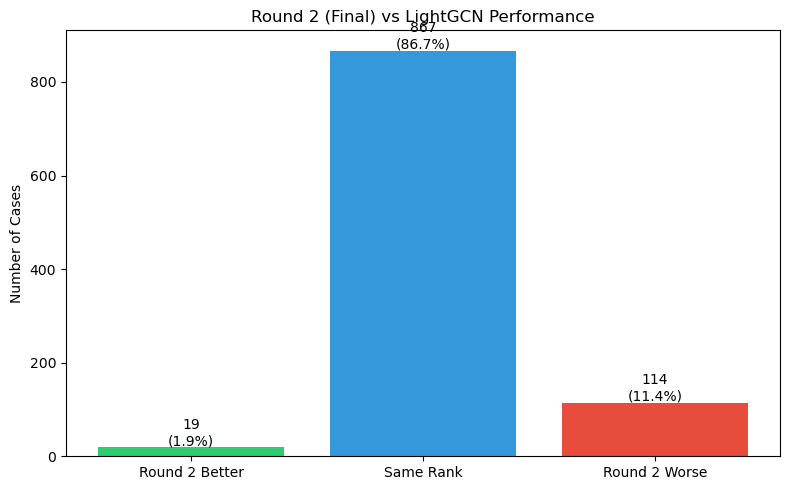

In [29]:
# Compare Round 2 vs LightGCN overall
fig, ax = plt.subplots(figsize=(8, 5))

comparison = [
    ('Round 2 Better', len(improved_cases), '#2ecc71'),
    ('Same Rank', (df['final_rank'] == df['lightgcn_rank']).sum(), '#3498db'),
    ('Round 2 Worse', (df['final_rank'] > df['lightgcn_rank']).sum(), '#e74c3c')
]

labels, values, colors = zip(*comparison)
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel('Number of Cases')
ax.set_title('Round 2 (Final) vs LightGCN Performance')

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{val}\n({val/len(df)*100:.1f}%)', ha='center')

plt.tight_layout()
plt.show()

## 7. Summary & Key Findings

In [30]:
# Generate summary statistics
summary = f"""
# Summary of Reranking Analysis

## Dataset
- Total samples: {len(df)}
- Ground truth added to candidates: {df['ground_truth_added'].sum()} ({df['ground_truth_added'].mean()*100:.1f}%)

## Performance Metrics (Hit@1)
- Round 1 (LLM only): {(df['round1_rank'] == 1).mean()*100:.1f}%
- LightGCN: {(df['lightgcn_rank'] == 1).mean()*100:.1f}%
- Final (Round 2): {(df['final_rank'] == 1).mean()*100:.1f}%

## Mean Rank (lower is better)
- Round 1: {df['round1_rank'].mean():.2f}
- LightGCN: {df['lightgcn_rank'].mean():.2f}
- Final: {df['final_rank'].mean():.2f}

## Key Findings

### Q1: Ground Truth in Candidates
- {df['ground_truth_added'].sum()} cases ({df['ground_truth_added'].mean()*100:.1f}%) required adding ground truth to candidates
- This indicates the candidate generation step misses the correct item in these cases

### Q2: LightGCN vs Round 1
- LightGCN better: {(df['lightgcn_rank'] < df['round1_rank']).sum()} cases
- Same rank: {(df['lightgcn_rank'] == df['round1_rank']).sum()} cases  
- LightGCN worse: {(df['lightgcn_rank'] > df['round1_rank']).sum()} cases

### Q3: Round 2 Hurting LightGCN Advantage
- When LightGCN was better, Round 2 made it worse in {len(hurt_cases)} cases
- Common patterns: Over-reliance on LLM rankings, negative score misinterpretation

### Q4: Round 2 Improvements
- Round 2 improved over LightGCN in {len(improved_cases)} cases ({len(improved_cases)/len(df)*100:.1f}%)
- Mean improvement: {improved_cases['improvement'].mean():.2f} positions when it helps
"""

display(Markdown(summary))


# Summary of Reranking Analysis

## Dataset
- Total samples: 1000
- Ground truth added to candidates: 978 (97.8%)

## Performance Metrics (Hit@1)
- Round 1 (LLM only): 16.1%
- LightGCN: 76.4%
- Final (Round 2): 69.9%

## Mean Rank (lower is better)
- Round 1: 3.22
- LightGCN: 1.46
- Final: 1.64

## Key Findings

### Q1: Ground Truth in Candidates
- 978 cases (97.8%) required adding ground truth to candidates
- This indicates the candidate generation step misses the correct item in these cases

### Q2: LightGCN vs Round 1
- LightGCN better: 739 cases
- Same rank: 196 cases  
- LightGCN worse: 65 cases

### Q3: Round 2 Hurting LightGCN Advantage
- When LightGCN was better, Round 2 made it worse in 94 cases
- Common patterns: Over-reliance on LLM rankings, negative score misinterpretation

### Q4: Round 2 Improvements
- Round 2 improved over LightGCN in 19 cases (1.9%)
- Mean improvement: 1.42 positions when it helps


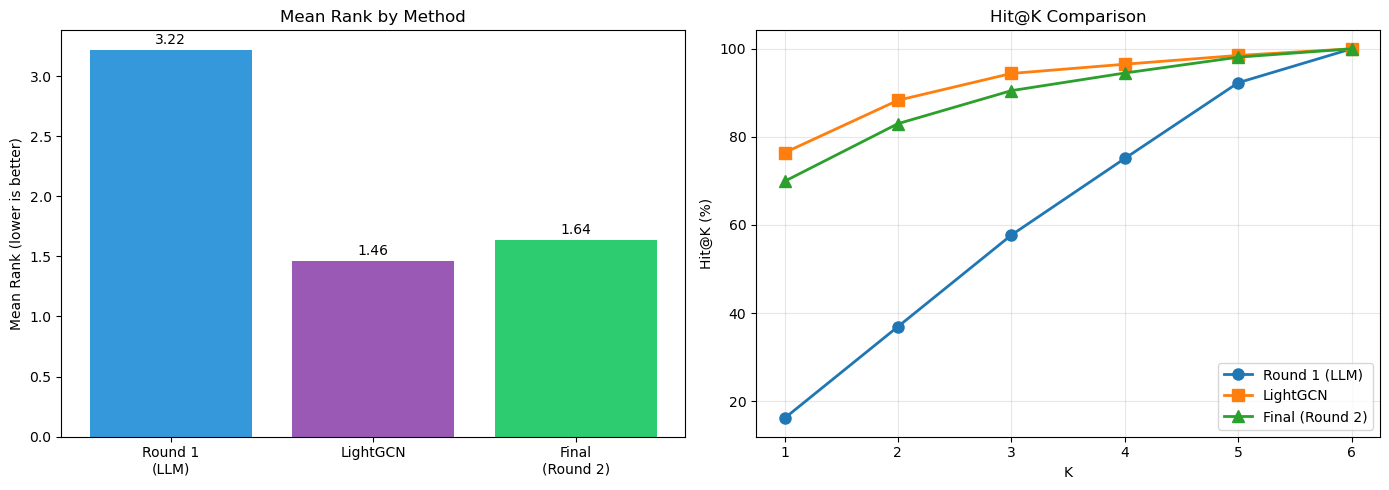

In [31]:
# Final visualization: Overall pipeline comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean rank comparison
ax1 = axes[0]
methods = ['Round 1\n(LLM)', 'LightGCN', 'Final\n(Round 2)']
mean_ranks = [df['round1_rank'].mean(), df['lightgcn_rank'].mean(), df['final_rank'].mean()]
bars = ax1.bar(methods, mean_ranks, color=['#3498db', '#9b59b6', '#2ecc71'])
ax1.set_ylabel('Mean Rank (lower is better)')
ax1.set_title('Mean Rank by Method')
for bar, val in zip(bars, mean_ranks):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.2f}', ha='center')

# Right: Hit@K curves
ax2 = axes[1]
ks = range(1, 7)
r1_hits = [(df['round1_rank'] <= k).mean()*100 for k in ks]
lgcn_hits = [(df['lightgcn_rank'] <= k).mean()*100 for k in ks]
final_hits = [(df['final_rank'] <= k).mean()*100 for k in ks]

ax2.plot(ks, r1_hits, 'o-', label='Round 1 (LLM)', linewidth=2, markersize=8)
ax2.plot(ks, lgcn_hits, 's-', label='LightGCN', linewidth=2, markersize=8)
ax2.plot(ks, final_hits, '^-', label='Final (Round 2)', linewidth=2, markersize=8)
ax2.set_xlabel('K')
ax2.set_ylabel('Hit@K (%)')
ax2.set_title('Hit@K Comparison')
ax2.legend()
ax2.set_xticks(ks)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()